## To do list:



## Possible ways to improve model performance

* Add atmospheric CO2
* Apply your better spike removal code to the other sites
* Try the interpolated precip from PRISM
* Try random forest model
* Interpolate missing CO2 and soil moisture (try single site interpolation)
* Try neural net model
* Use latitude instead of site number
* Add elevation
* Add land cover type (maybe we should try biomass carbon density maps instead)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive 
# list of all potential features across all pits
features = ['CO2', 'timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 
            'WaterPotential', 'ReductionPotential', 'Pit', 'Depth', 'Site', 'Season']
m = len(features)

# Define site and pit number indices
site_nos = {'Calhoun': 0, 'Shale_Hills': 2, 
            'Catalina-Jemez': 1, 'Seca_Floresta': 3}
pit_nos = {}
i = 0
for site, pits in all_pits.items():
    for pit in pits:
        pit_nos[pit] = i
        i += 1
        
# Remove pits with manual samples
del all_pits['Seca_Floresta']
all_pits['Calhoun'].remove('R1C2')
all_pits['Shale_Hills'].remove('SPMS')

In [2]:
total_count = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        with open(infile) as f:
            for i, l in enumerate(f):
                pass
        nlines = i + 1
        total_count += nlines
        print(site, pit, '--', nlines)
print(total_count)

Calhoun R1C1 -- 28388
Calhoun R1H1 -- 28394
Calhoun R1P1 -- 28393
Catalina-Jemez BGZOB1 -- 27277
Catalina-Jemez BGZOB2 -- 27302
Catalina-Jemez BGZOB3 -- 27297
Catalina-Jemez BGZOB4 -- 27275
Catalina-Jemez Green1 -- 27976
Catalina-Jemez Green2 -- 6995
Catalina-Jemez Green3 -- 27975
Catalina-Jemez MC1 -- 72374
Catalina-Jemez MC2 -- 72658
Catalina-Jemez MC3 -- 72539
Catalina-Jemez MC4 -- 72540
Catalina-Jemez MC5 -- 71698
Catalina-Jemez MC6 -- 72539
Shale_Hills LRMS -- 14137
Shale_Hills NPMS -- 34448
Shale_Hills SPVF -- 2999
Shale_Hills TMMS -- 35403
778607


In [3]:
# Load in and merge all files
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        df = pd.read_csv(infile, parse_dates=[0], na_values=[-99999])

        # Remove records without any CO2 data
        co2_cols = [col for col in df.columns if 'CO2' in col]
        df = df[~df.loc[:, co2_cols].isna().all(axis=1)]
        
        depths = []
        for col in df.columns:
            if ('precip' not in col) and ('DateTime' not in col):
                depths.append(col.split('_')[1].split('cm')[0])
        unique_depths = list(set(depths))

        # t is the number of time steps
        t = df.shape[0]

        # data shape is the # of observations (# time points * depths), # features
        cur_data = np.empty((t*len(unique_depths), m))
        cur_data[:] = np.nan

        for i, depth in enumerate(unique_depths):
            depth_cols = [col for col in df.columns if '_%scm' % depth in col]
            for j, feature in enumerate(features):
                # Look for columns with this feature and depth in the name
                if feature == 'precip':
                    col = 'PRISM_precip.mm'
                elif feature == 'timestamp':
                    col = [col for col in df.columns if 'DateTime' in col]
                    col = col[0]
                elif feature == 'Season':
                    col = [col for col in df.columns if 'DateTime' in col]
                    df['quarter'] = df[col[0]].dt.quarter
                    col = 'quarter'
                else:
                    matches = [col for col in depth_cols if feature in col]

                    # Correct for fact that "O2" search returns "CO2" as well
                    if feature == 'O2':
                        matches = [col for col in matches if 'CO2' not in col]

                    if len(matches) > 1:
                        raise ValueError("""More than one possible match found for 
                        %s %s %scm %s""" %(site, pit, depth, feature))
                    elif len(matches) == 1:
                        col = matches[0]
                    else:
                        col = ""
                        continue
    
                # Now that we have the column name, add this subset to cur_data
                cur_data[i*t:(i+1)*t, j] = df[col].values

            # Add in depth
            cur_data[i*t:(i+1)*t, features.index('Depth')] = depth
        
        # Add in pit and site indices
        cur_data[:, features.index('Pit')] = pit_nos[pit]
        cur_data[:, features.index('Site')] = site_nos[site]
        
        # Copy current data to dict of all data
        data[pit] = cur_data.copy()

In [4]:
# Merge all data into a single numpy array
for i, (pit, array) in enumerate(data.items()):
    if i == 0:
        merged = array.copy()
    else:
        merged = np.append(merged, array, axis=0)

# Remove rows without any CO2 data
all_rows, _ = merged.shape
merged = merged[~np.isnan(merged[:, 0]), :]
trimmed = all_rows - merged.shape[0]
print(f'Removed {trimmed:,} rows without CO2 data')

df = pd.DataFrame(data=merged, columns=features)

Removed 115,759 rows without CO2 data


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [6]:
#For the nearest neighbors model, run this cell and all subsequent cells

df.drop(columns=['WaterPotential', 'ReductionPotential'], 
        inplace=True)

df=df.dropna()
df

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
1,13570.00000,1.459382e+18,0.00,0.3580,0.044,16.70500,19.413019,0.0,50.0,0.0,1.0
2,13830.00000,1.459386e+18,0.00,0.3580,0.044,16.77000,19.417373,0.0,50.0,0.0,1.0
3,14100.00000,1.459390e+18,0.00,0.3580,0.044,16.83500,19.421726,0.0,50.0,0.0,1.0
4,14315.00000,1.459393e+18,0.00,0.3580,0.044,16.89000,19.425410,0.0,50.0,0.0,1.0
5,14515.00000,1.459397e+18,0.00,0.3580,0.044,16.94000,19.428758,0.0,50.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1389047,2293.51950,1.500181e+18,7.05,0.1780,0.000,15.29050,12.237500,16.0,30.0,1.0,3.0
1389048,2250.84025,1.500185e+18,7.05,0.1780,0.000,15.16400,12.252000,16.0,30.0,1.0,3.0
1389049,2227.83200,1.500188e+18,7.05,0.1775,0.000,15.07350,12.249500,16.0,30.0,1.0,3.0
1389050,2204.82800,1.500192e+18,7.05,0.1770,0.000,15.01625,12.255750,16.0,30.0,1.0,3.0


In [76]:
#Model Comparison code starts below. Only cells 1-7 (except 5) need to be run in order to start the model comparison section.
df_nan.CO2.loc[(df_nan.Pit==4) & (df_nan.Depth==60)]=np.nan
df_nan.CO2.loc[df_nan.Pit==4][df_nan.Depth==60]


75650    NaN
75651    NaN
75652    NaN
75653    NaN
75654    NaN
          ..
102117   NaN
102118   NaN
102119   NaN
102120   NaN
102121   NaN
Name: CO2, Length: 26279, dtype: float64

10736.281774210856


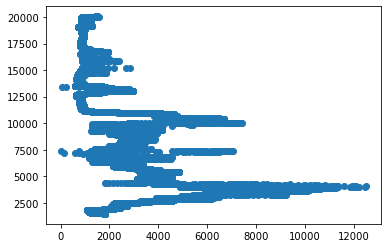

In [77]:
#Run this for systematically missing values
from sklearn import metrics

df_nan=df.copy(deep=True)
df_nan.CO2.loc[(df_nan.Pit==4) & (df_nan.Depth==60)]=np.nan

#df_nan.SoilMoisture.loc[df_nan.sample(frac=0.5).index] = np.nan



nan_index=df_nan[df_nan.CO2.notna()==False]
not_nan_index=df_nan[df_nan.CO2.notna()==True]


df_nan_linear=df_nan.copy(deep=True)
df_nan_median=df_nan.copy(deep=True)

df_nan_median.CO2=df_nan_median.CO2.fillna(np.nanmedian(df_nan_median.CO2))


df_nan_linear=df_nan_linear.interpolate()

df_nan_linear.CO2=df_nan_linear.CO2.fillna(np.nanmedian(df_nan_linear.CO2))


print(metrics.mean_squared_error(df_nan_linear.CO2.loc[nan_index.index], df.CO2.loc[nan_index.index], squared=False))
plt.scatter(df.CO2.loc[nan_index.index], df_nan_linear.CO2.loc[nan_index.index])


In [255]:
#Run this to train the model on whatever not_nan_index you have defined

df_st =  StandardScaler().fit_transform(df_nan.loc[not_nan_index.index]) 
df_st1=pd.DataFrame(data=df_st)
#df_st1.index=not_nan_index.index
#df_st1=df_st1.dropna()
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
#X=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth']]  # Features\n",

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
X=df_st1[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Pit','Depth','Site']]
y=df_st1['CO2']  # Labels\n",


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.99)

from sklearn.neural_network import MLPRegressor
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn import metrics

#neigh = KNeighborsRegressor(n_neighbors=3)
#neigh.fit(X_train, y_train)
#print(neigh.score(X_test,y_test))

neural=MLPRegressor(hidden_layer_sizes=(20), batch_size=500, learning_rate='adaptive',solver='sgd', max_iter=200, random_state=2)
neural.fit(X_train, y_train)
print(neural.score(X_test,y_test))

0.787824315769069


C:\Users\marcb\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [256]:
st_nan=  StandardScaler().fit_transform(df_nan.loc[nan_index.index])
df_st_nan=pd.DataFrame(data=st_nan)

df_st_nan.index=nan_index.index


df_st_nan.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
X_nan=df_st_nan[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Pit','Depth','Site']]
y_nan=df_st_nan['CO2']  # Labels\n",


#CO2_predict=neigh.predict(X_nan)
#CO2_predict_df=pd.DataFrame(data=CO2_predict)
#CO2_predict_df.index=nan_index.index

CO2_neural_predict=neural.predict(X_nan)
CO2_neural_predict_df=pd.DataFrame(data=CO2_neural_predict)
CO2_neural_predict_df.index=nan_index.index

CO2_predict_original=CO2_predict_df*np.std(df_nan['CO2'].loc[not_nan_index.index])+np.mean(df_nan.CO2.loc[not_nan_index.index])
CO2_neural_predict_original=CO2_neural_predict_df*np.std(df_nan['CO2'].loc[not_nan_index.index])+np.mean(df_nan.CO2.loc[not_nan_index.index])



C:\Users\marcb\anaconda3\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\marcb\anaconda3\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [257]:
#Max_iter=200
    #hidden_layer_size=400: RMSE=4307
    #hidden_layer_size=100: RMSE=5016
    #hidden_layer_size=1000: RMSE=4020
#Max_iter=2000
    #hidden_layer_size=400: RMSE=4307
    #hidden_layer_size=100: RMSE=5016
    #hidden_layer_size=1000: RMSE=3890
#Max_iter=2000
    #hidden_layer_size=2000:  
        #batch_size=2000: RMSE=3731
a=df.CO2.loc[nan_index.index]
b=CO2_predict_original
c=CO2_neural_predict_original
d=df_nan_linear.CO2.loc[nan_index.index]
e=df_nan_median.CO2.loc[nan_index.index]

print('kNN without lag RMSE:',metrics.mean_squared_error(a, b, squared=False))
print('Neural RMSE:',metrics.mean_squared_error(a, c, squared=False))
print('Linear RMSE:', metrics.mean_squared_error(a, d, squared=False))
print('Median RMSE:', metrics.mean_squared_error(a, e, squared=False))


print(metrics.mean_absolute_error(a, b))
print(metrics.mean_absolute_error(a, c))
print(metrics.mean_absolute_error(a, d))
print(metrics.mean_absolute_error(a, e))



print(np.var(df.SoilMoisture))





kNN without lag RMSE: 3476.7132353631723
Neural RMSE: 3621.6936106276953
Linear RMSE: 10736.281774210856
Median RMSE: 2173.6052901758662
2495.1852692539383
2744.2708157840866
8958.861372632653
1833.3564027265118
0.007892823381031528


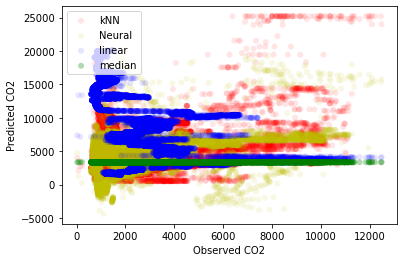

In [230]:
#print(metrics.mean_squared_error(ab, bc, squared=False))
#plt.scatter(a, b)


fig, ax = plt.subplots()

ax.scatter(a, b, c='r', label='kNN',
               alpha=0.1, edgecolors='none')

ax.scatter(a, c, c='y', label='Neural',
               alpha=0.1, edgecolors='none')

ax.scatter(a, d, c='b', label='linear',
               alpha=0.1, edgecolors='none')

ax.scatter(a, e, c='g', label='median',
               alpha=0.3, edgecolors='none')
ax.legend(loc=2)
ax.set_xlabel('Observed CO2')
ax.set_ylabel('Predicted CO2')
plt.show()


In [88]:
import hydroeval as he


print( he.evaluator(he.nse, a, b))
print( he.evaluator(he.nse, a, c))
print( he.evaluator(he.nse, a, d))




[-0.4119316]


NameError: name 'c' is not defined

In [89]:
from sklearn.metrics import r2_score
print (r2_score(a, b))
print (r2_score(a, d))
nan_index

-2.070177628740473
-28.18521064996826


,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
75650,NaN,1.417518e+18,0.00,0.006333,0.0000,7.17175,21.23625,4.0,60.0,1.0,4.0
75651,NaN,1.417522e+18,0.85,0.005500,0.0000,7.17650,21.20800,4.0,60.0,1.0,4.0
75652,NaN,1.417525e+18,0.85,0.006750,0.0000,7.18650,21.19650,4.0,60.0,1.0,4.0
75653,NaN,1.417529e+18,0.85,0.007000,0.0000,7.18725,21.21300,4.0,60.0,1.0,4.0
75654,NaN,1.417532e+18,0.85,0.007000,0.0000,7.19425,21.21800,4.0,60.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
102117,NaN,1.514664e+18,0.00,0.003000,0.0050,6.68650,20.35925,4.0,60.0,1.0,4.0
102118,NaN,1.514668e+18,0.00,0.003000,0.0025,6.70300,20.35950,4.0,60.0,1.0,4.0
102119,NaN,1.514671e+18,0.00,0.003000,0.0050,6.70900,20.38000,4.0,60.0,1.0,4.0
102120,NaN,1.514675e+18,0.00,0.003000,0.0025,6.72150,20.37750,4.0,60.0,1.0,4.0


In [17]:
len(nan_index)/len(df)

0.005161791044776119

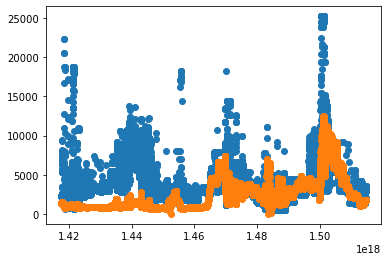

In [99]:
plt.scatter(nan_index.timestamp,b)
plt.scatter(nan_index.timestamp,a)

In [ ]:
df_nan